In [17]:
import matplotlib.pyplot as plt
import scipy.io as sio

In [18]:
mat = sio.loadmat('capacity_test.mat')

In [19]:
print(sorted(mat.keys()))

['__globals__', '__header__', '__version__', 'cap', 'col_cell_label', 'curr', 'row_diag_number', 'time', 'vcell']


In [20]:
# this is all the battery labels i.e. each label is a sepearte lgm50 battery
mat['col_cell_label']

array([[array(['W3'], dtype='<U2'), array(['W4'], dtype='<U2'),
        array(['W5'], dtype='<U2'), array(['W7'], dtype='<U2'),
        array(['W8'], dtype='<U2'), array(['W9'], dtype='<U2'),
        array(['W10'], dtype='<U3'), array(['G1'], dtype='<U2'),
        array(['V4'], dtype='<U2'), array(['V5'], dtype='<U2')]],
      dtype=object)

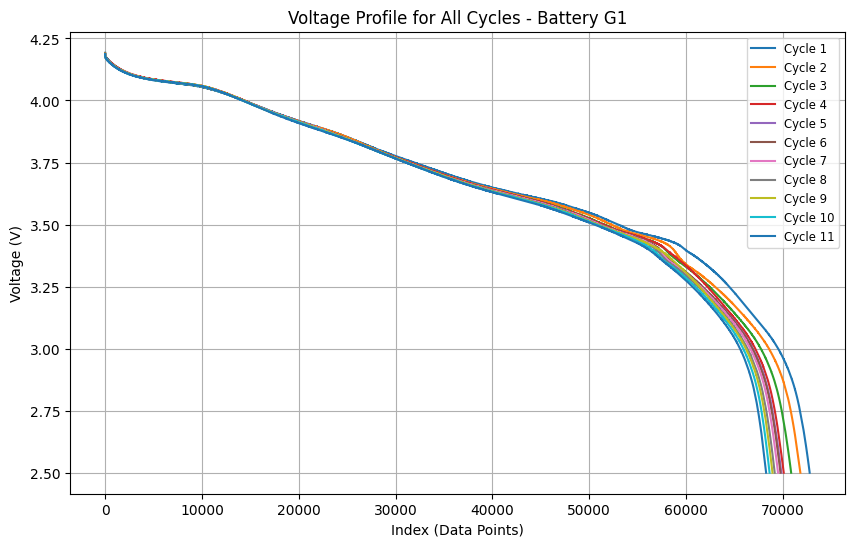

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio  

mat = sio.loadmat('capacity_test.mat')

battery_label = 'G1'
col_index = np.where([label[0] == battery_label for label in mat['col_cell_label'][0]])[0][0]

# Iterate over all rows of vcell for the specified column index
vcell_all_cycles = mat['vcell'][:, col_index]  

plt.figure(figsize=(10, 6))
for i, vcell_cycle in enumerate(vcell_all_cycles):
    if vcell_cycle.size > 1 and not np.isnan(vcell_cycle).all():  # Skip empty or NaN rows
        vcell = vcell_cycle[~np.isnan(vcell_cycle)].reshape(-1)  # Remove NaN and flatten
        plt.plot(vcell, label=f"Cycle {i+1}")

# Plot formatting
plt.xlabel("Index (Data Points)")
plt.ylabel("Voltage (V)")
plt.title(f"Voltage Profile for All Cycles - Battery {battery_label}")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.show()


In [22]:
mat['col_cell_label']

array([[array(['W3'], dtype='<U2'), array(['W4'], dtype='<U2'),
        array(['W5'], dtype='<U2'), array(['W7'], dtype='<U2'),
        array(['W8'], dtype='<U2'), array(['W9'], dtype='<U2'),
        array(['W10'], dtype='<U3'), array(['G1'], dtype='<U2'),
        array(['V4'], dtype='<U2'), array(['V5'], dtype='<U2')]],
      dtype=object)

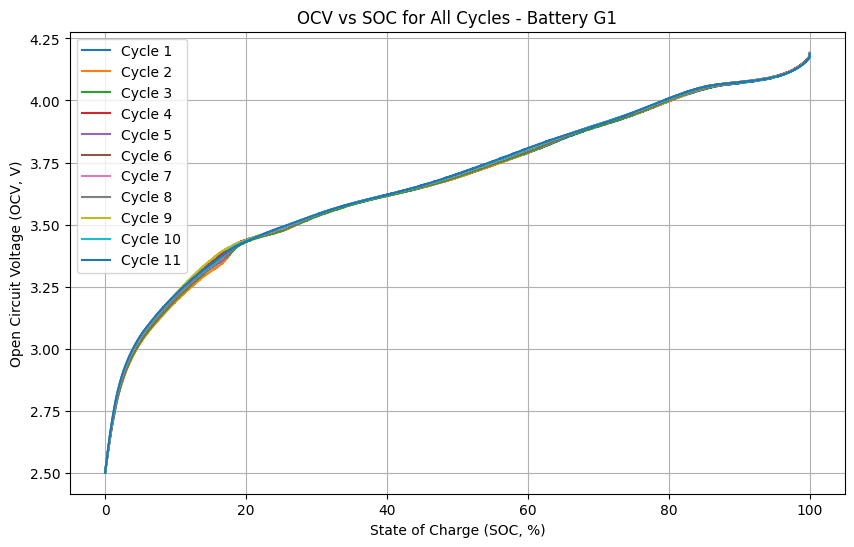

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio  

# Load the data
mat = sio.loadmat('capacity_test.mat')

# Select the data for the specific battery cell
battery_label = 'G1'

col_index = np.where([label[0] == battery_label for label in mat['col_cell_label'][0]])[0][0]
vcell = mat['vcell'][:, col_index]
current = mat['curr'][:, col_index]
cap = mat['cap'][:, col_index]

Q_end = []
SOC = []
OCV = []

# Check if the number of cycles in `cap` and `vcell` match
num_cycles = min(len(cap), len(vcell)) 

# Loop over the cycles and extract the OCV-SOC relationship
for i in range(num_cycles):
    capacity = cap[i]
    
    if capacity.size > 1 and not np.isnan(capacity).all():  # Skip empty or NaN rows
        cap_cycle = capacity[~np.isnan(capacity)].reshape(-1)  # Remove NaN and flatten

        # Calculate SOC
        Q_end = cap_cycle[-1]
        # (current_capacity / capacity_end_of_cycle) * 100
        soc_cycle = (cap_cycle / Q_end) * 100  # SOC from 0% to 100% based on last capacity in the cycle
        # SoC from 100% to 0%
        soc_cycle = 100 - soc_cycle.flatten() # Invert SOC for data orientation
        
        SOC.append(soc_cycle)
        
        # Extract corresponding OCV for the current cycle
        vcell_cycle = vcell[i].flatten()  # Access the i-th voltage cycle from vcell and flatten to be used in data fitting
        OCV.append(vcell_cycle)

# Plot OCV vs SOC for each cycle
plt.figure(figsize=(10, 6))
for i in range(len(SOC)):
    plt.plot(SOC[i], OCV[i], label=f"Cycle {i+1}")

plt.xlabel("State of Charge (SOC, %)")
plt.ylabel("Open Circuit Voltage (OCV, V)")
plt.title(f"OCV vs SOC for All Cycles - Battery {battery_label}")
plt.legend()
plt.grid(True)
plt.show()

SOC_flat = np.concatenate(SOC)
OCV_flat = np.concatenate(OCV)

# Fit polynomial 
degree = 11
coeffs = np.polyfit(SOC_flat, OCV_flat, degree)
# Create a polynomial function
poly_fit = np.poly1d(coeffs)    

# Generate smooth SOC values for plotting the fit curve
SOC_smooth = np.linspace(min(SOC_flat), max(SOC_flat), 100)
OCV_smooth = poly_fit(SOC_smooth)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(SOC_flat, OCV_flat, label="Measured Data", color='blue', alpha=0.6)
plt.plot(SOC_smooth, OCV_smooth, label=f"Fitted Polynomial (Degree {degree})", color='red', linewidth=2)
plt.xlabel("State of Charge (SOC, %)")
plt.ylabel("Open Circuit Voltage (OCV, V)")
plt.title(f"OCV vs SOC - Battery {battery_label}")
plt.legend()
plt.grid(True)
plt.show()

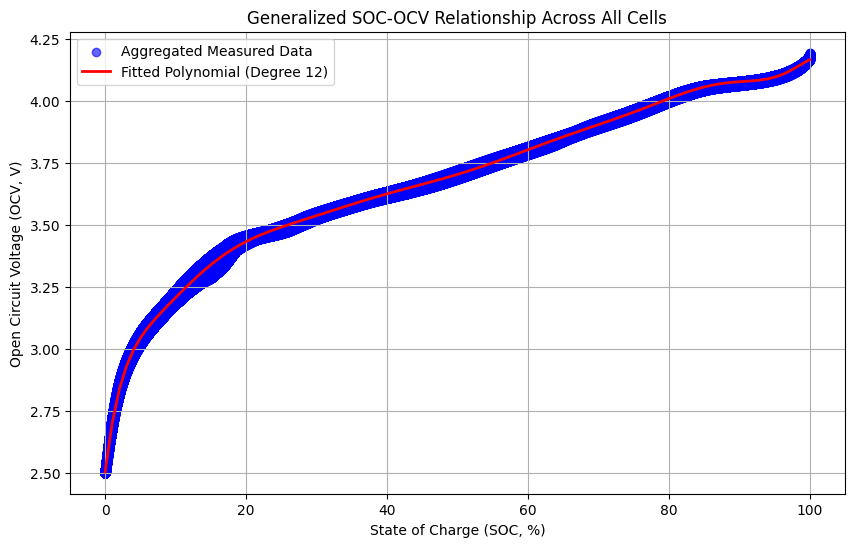

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# Load the capacity test data
capacity_data = sio.loadmat('capacity_test.mat')

# Initialize lists to store aggregated SOC-OCV data
all_SOC = []
all_OCV = []

# Iterate through all battery cells in the dataset
for battery_label in capacity_data['col_cell_label'][0]:
    battery_label = battery_label[0]  # Extract label string
    col_index = np.where([label[0] == battery_label for label in capacity_data['col_cell_label'][0]])[0][0]
    
    # Extract vcell, current, and capacity data for this cell
    vcell = capacity_data['vcell'][:, col_index]
    cap = capacity_data['cap'][:, col_index]
    
    num_cycles = min(len(cap), len(vcell))
    
    for i in range(num_cycles):
        capacity = cap[i]
        
        if capacity.size > 1 and not np.isnan(capacity).all():  # Skip empty or NaN rows
            cap_cycle = capacity[~np.isnan(capacity)].reshape(-1)  # Remove NaN and flatten
            Q_end = cap_cycle[-1]
            
            # Calculate SOC
            soc_cycle = (cap_cycle / Q_end) * 100  # SOC from 0% to 100%
            soc_cycle = 100 - soc_cycle.flatten()  # Invert SOC for data orientation
            
            # Extract corresponding OCV for the current cycle
            vcell_cycle = vcell[i].flatten()
            
            # Append to aggregated lists
            all_SOC.append(soc_cycle)
            all_OCV.append(vcell_cycle)

# Combine all SOC and OCV data
all_SOC_flat = np.concatenate(all_SOC)
all_OCV_flat = np.concatenate(all_OCV)

# Fit a polynomial to the aggregated data
degree = 12
coeffs = np.polyfit(all_SOC_flat, all_OCV_flat, degree)
poly_fit = np.poly1d(coeffs)

# Generate smooth SOC values for plotting
SOC_smooth = np.linspace(min(all_SOC_flat), max(all_SOC_flat), 100)
OCV_smooth = poly_fit(SOC_smooth)

# Plot the aggregated data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(all_SOC_flat, all_OCV_flat, label="Aggregated Measured Data", color='blue', alpha=0.6)
plt.plot(SOC_smooth, OCV_smooth, label=f"Fitted Polynomial (Degree {degree})", color='red', linewidth=2)
plt.xlabel("State of Charge (SOC, %)")
plt.ylabel("Open Circuit Voltage (OCV, V)")
plt.title("Generalized SOC-OCV Relationship Across All Cells")
plt.legend()
plt.grid(True)
plt.show()

  SOC      OCV
  0.0 2.503168
  1.0 2.699464
  2.0 2.834200
  3.0 2.927470
  4.0 2.993730
  5.0 3.043114
  6.0 3.082490
  7.0 3.116309
  8.0 3.147280
  9.0 3.176889
 10.0 3.205807
 11.0 3.234190
 12.0 3.261899
 13.0 3.288658
 14.0 3.314162
 15.0 3.338141
 16.0 3.360401
 17.0 3.380834
 18.0 3.399428
 19.0 3.416249
 20.0 3.431428
 21.0 3.445149
 22.0 3.457621
 23.0 3.469067
 24.0 3.479708
 25.0 3.489749
 26.0 3.499369
 27.0 3.508719
 28.0 3.517916
 29.0 3.527041
 30.0 3.536146
 31.0 3.545253
 32.0 3.554360
 33.0 3.563449
 34.0 3.572489
 35.0 3.581444
 36.0 3.590275
 37.0 3.598951
 38.0 3.607447
 39.0 3.615751
 40.0 3.623862
 41.0 3.631794
 42.0 3.639573
 43.0 3.647240
 44.0 3.654842
 45.0 3.662437
 46.0 3.670083
 47.0 3.677842
 48.0 3.685772
 49.0 3.693925
 50.0 3.702343
 51.0 3.711059
 52.0 3.720090
 53.0 3.729442
 54.0 3.739104
 55.0 3.749052
 56.0 3.759252
 57.0 3.769655
 58.0 3.780210
 59.0 3.790856
 60.0 3.801535
 61.0 3.812191
 62.0 3.822772
 63.0 3.833239
 64.0 3.843562
 65.0 3.85

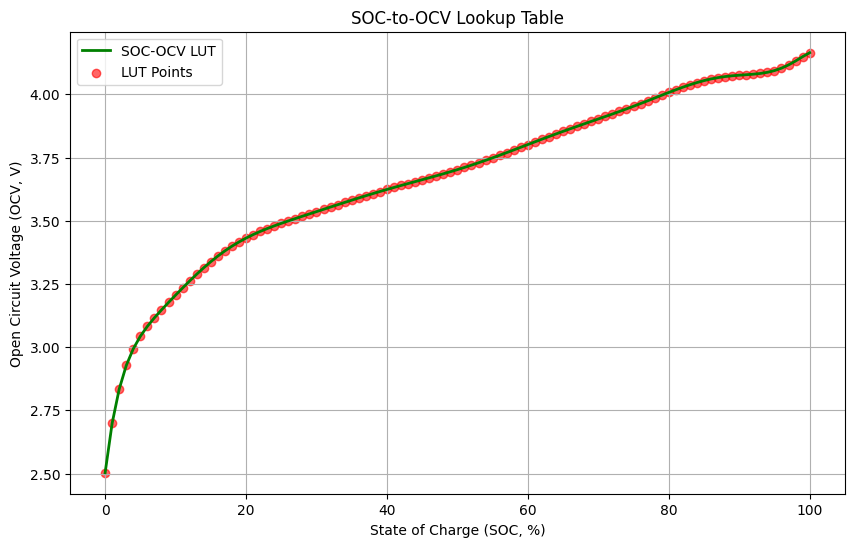

In [38]:
import os
import pandas as pd 

# Define the SOC range for the LUT
SOC_LUT = np.linspace(0, 100, 101)  # 101 points from 0% to 100% SOC
OCV_LUT = poly_fit(SOC_LUT)  # Compute OCV for each SOC level using the fitted polynomial

# Combine SOC and OCV into a LUT
lut = np.column_stack((SOC_LUT, OCV_LUT))  # Combine SOC and OCV values

# Optionally, convert to a Pandas DataFrame for better visualization
lut_df = pd.DataFrame(lut, columns=["SOC", "OCV"])

# Print the lookup table
print(lut_df.to_string(index=False))

output_folder = "soc_ocv"
output_file = os.path.join(output_folder, f"LGM50_soc_to_ocv.csv")
lut_df.to_csv(output_file, index=False)

# Plot the LUT for visualization
plt.figure(figsize=(10, 6))
plt.plot(SOC_LUT, OCV_LUT, label="SOC-OCV LUT", color='green', linewidth=2)
plt.scatter(SOC_LUT, OCV_LUT, color='red', alpha=0.6, label="LUT Points")
plt.xlabel("State of Charge (SOC, %)")
plt.ylabel("Open Circuit Voltage (OCV, V)")
plt.title("SOC-to-OCV Lookup Table")
plt.legend()
plt.grid(True)
plt.show()